### This reproduces the plots shown in the paper (along with some more random stuff)

In [2]:
import mne
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf, read_raw_eeglab

%matplotlib inline
sns.set_palette('muted')
sns.set_style('whitegrid')

font = {'family' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

## Getting the data

Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file


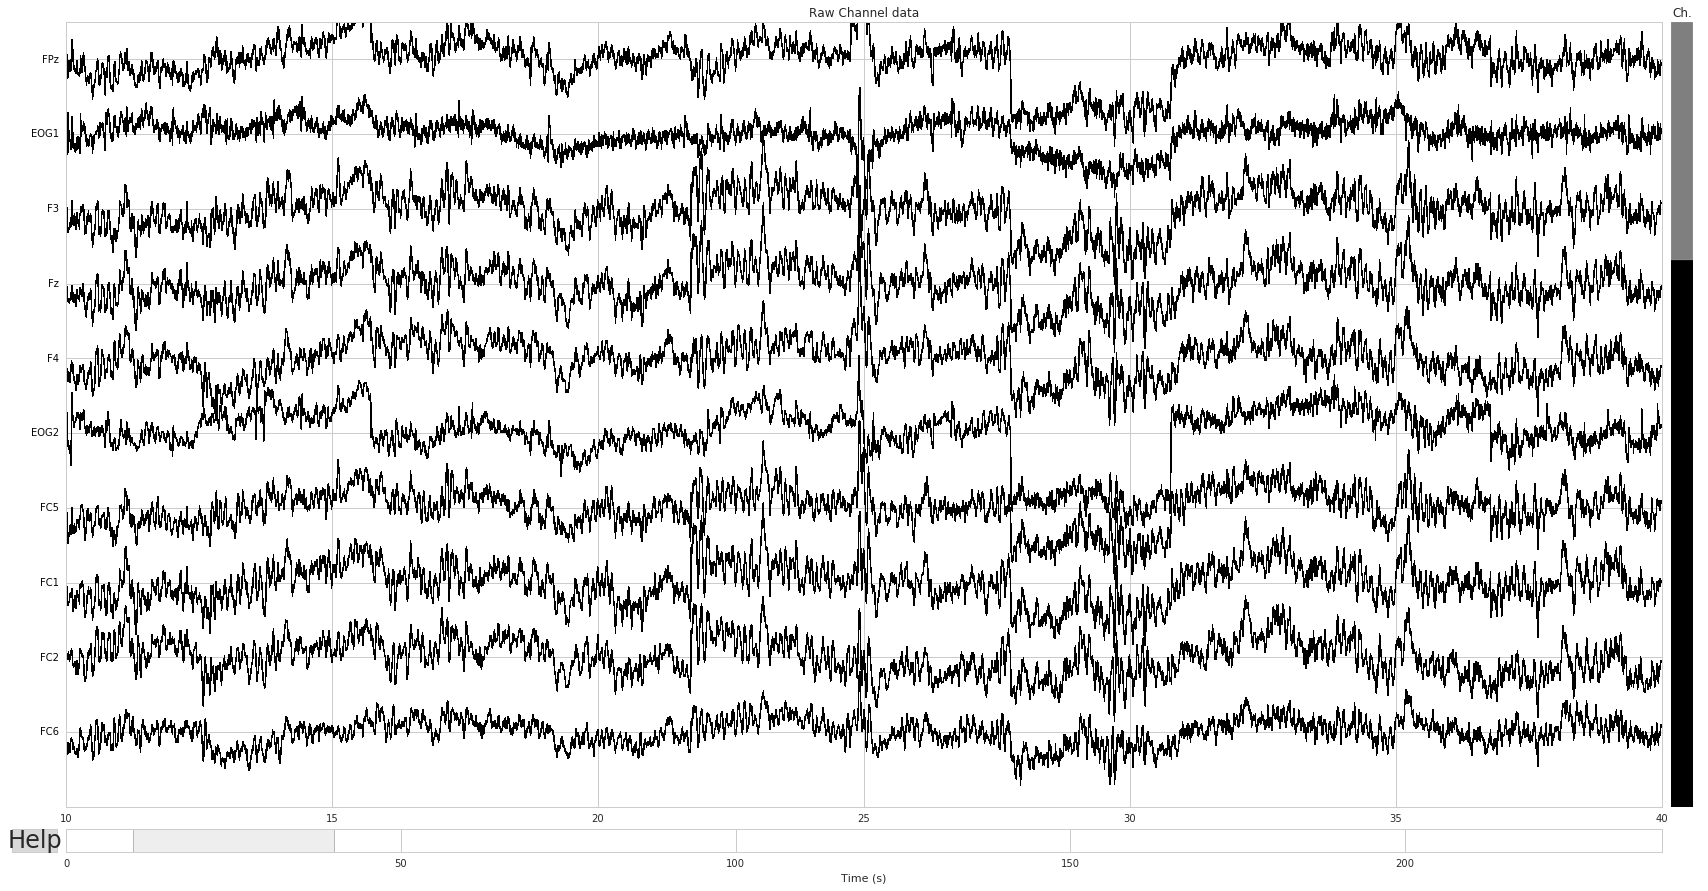

In [3]:
# from EEGLAB tutorial (EEGLAB itself continuously crashes on my Linux machine)
# and I didn't get the right events I think; in any case, it's not important for the following

channels = pd.read_csv('eeglab_chan32.locs', sep='\s+', header=None)
raw = read_raw_eeglab('eeglab_data.set', event_id=dict(square=1, rt=0))

old_names = raw.info.get('ch_names')[:-1]
new_names = channels.iloc[:, 3]

raw.rename_channels({k:v for k, v in zip(old_names, new_names)})

fig = mne.viz.plot_raw(raw, duration=30.0, start=10.0, scalings=dict(eeg=5e-5), title='Raw Channel data',
                       n_channels=10);

In [9]:
raw.info

<Info | 16 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : 'mne.io.meas_info._ChannelNameList | FPz, EOG1, F3, Fz, F4, EOG2, FC5, FC1, FC2, FC6
    chs : list | 33 items (EEG: 32, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 64.0 Hz
    meas_date : numpy.ndarray | 1970-01-01 01:00:00
    nchan : int | 33
    projs : list | 0 items
    sfreq : float | 128.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    filename : NoneType
    hpi_subsystem : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneT

In [11]:
# find the EEG electrodes and exclude bad ones
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

## Filtering

In [12]:
raw.filter(1, 25, copy=False) # bandpass filter

Band-pass filtering from 1 - 25 Hz


<RawEEGLAB  |  None, n_channels x n_times : 33 x 30504 (238.3 sec)>

## Epoching and Baselining

In [13]:
# get the events (stimulus presentation)
events = find_events(raw, shortest_event=0, stim_channel='STI 014')
events[:10, :]

80 events found
Events id: [1]


array([[ 129,    0,    1],
       [ 218,    0,    1],
       [ 603,    0,    1],
       [ 988,    0,    1],
       [1373,    0,    1],
       [1758,    0,    1],
       [2143,    0,    1],
       [2528,    0,    1],
       [2913,    0,    1],
       [3298,    0,    1]])

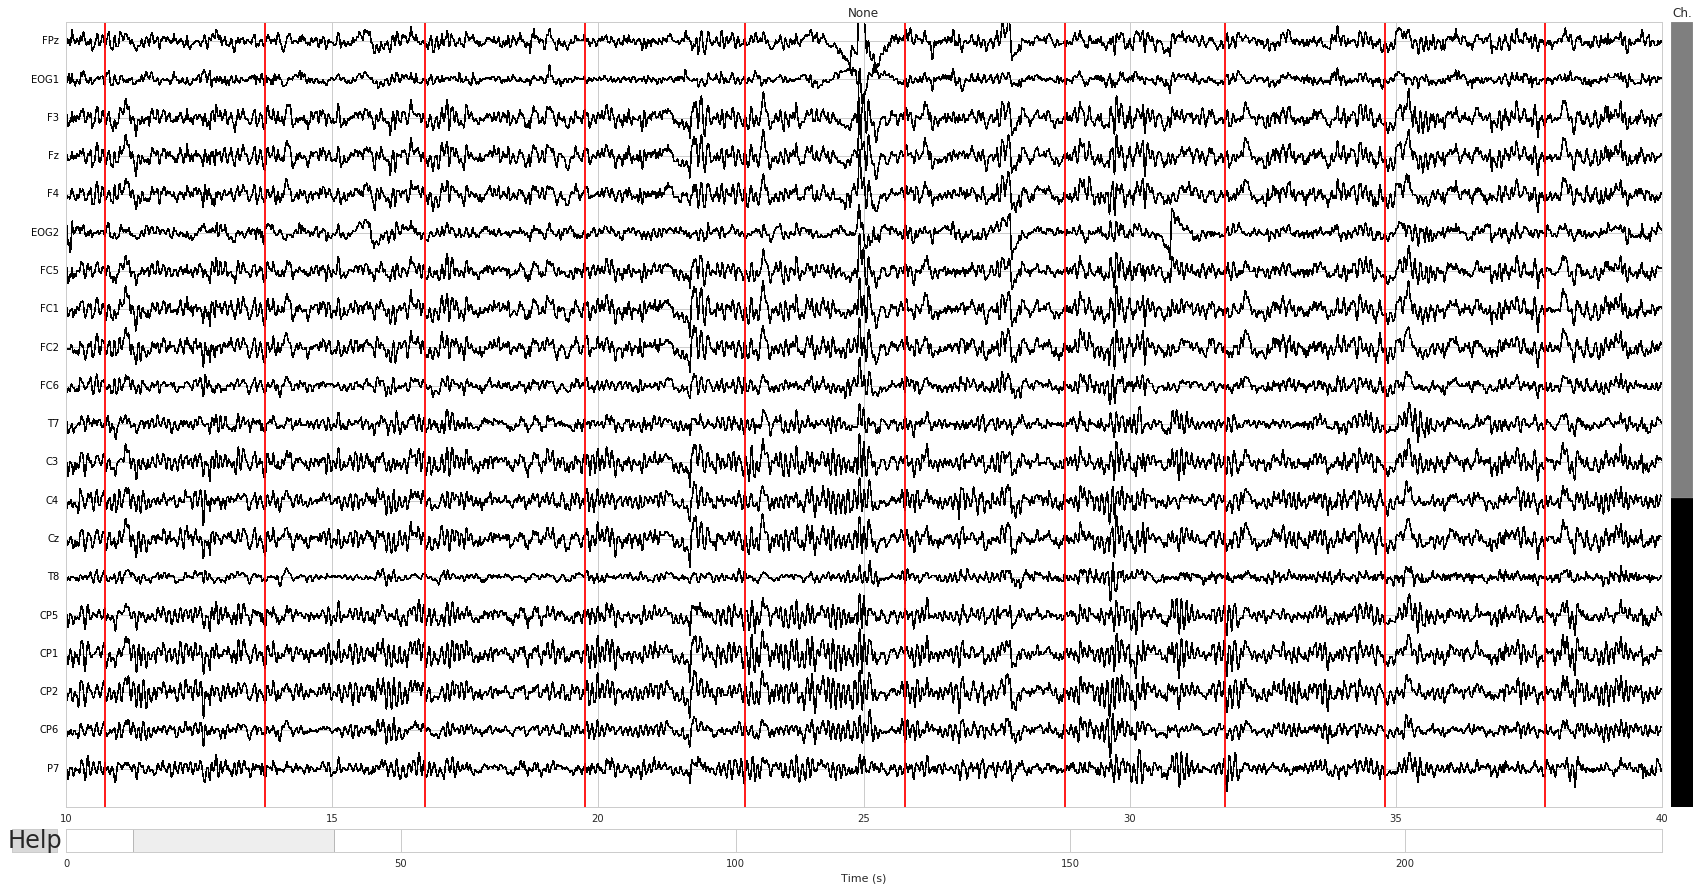

In [14]:
select = events[np.logical_or(events[:, 2] == 1, events[:, 2] == 2), :]
raw.plot(select, event_color='red', duration=30.0, start=10.0, scalings=dict(eeg=5e-5));

In [15]:
# extract the epochs based on the raw data and events
tmin, tmax = -.200, 1. # start time before an event, end time after an event
event_id = {'square': 1}

epochs = Epochs(raw, events, event_id, tmin, tmax, proj=False, picks=picks,
                baseline=(tmin, 0), preload=True, add_eeg_ref=False, verbose=False)

epochs1 = Epochs(raw, events, event_id, tmin, tmax, proj=False, picks=[0],
                baseline=(tmin, 0), preload=True, add_eeg_ref=False, verbose=False)

epochs

<Epochs  |  n_events : 80 (all good), tmin : -0.203125 (s), tmax : 1.0 (s), baseline : (-0.2, 0)>

## Butterfly plot

Converting time column to int64...


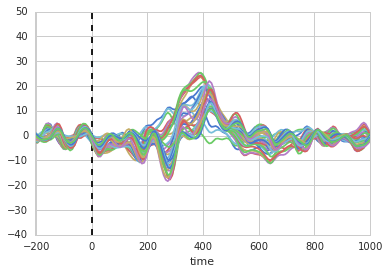

In [19]:
epochs.average().to_data_frame().plot(legend=False); # gives a broad overview of the electrodes
plt.vlines(0, -40, 50, linestyle='dashed');

Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...


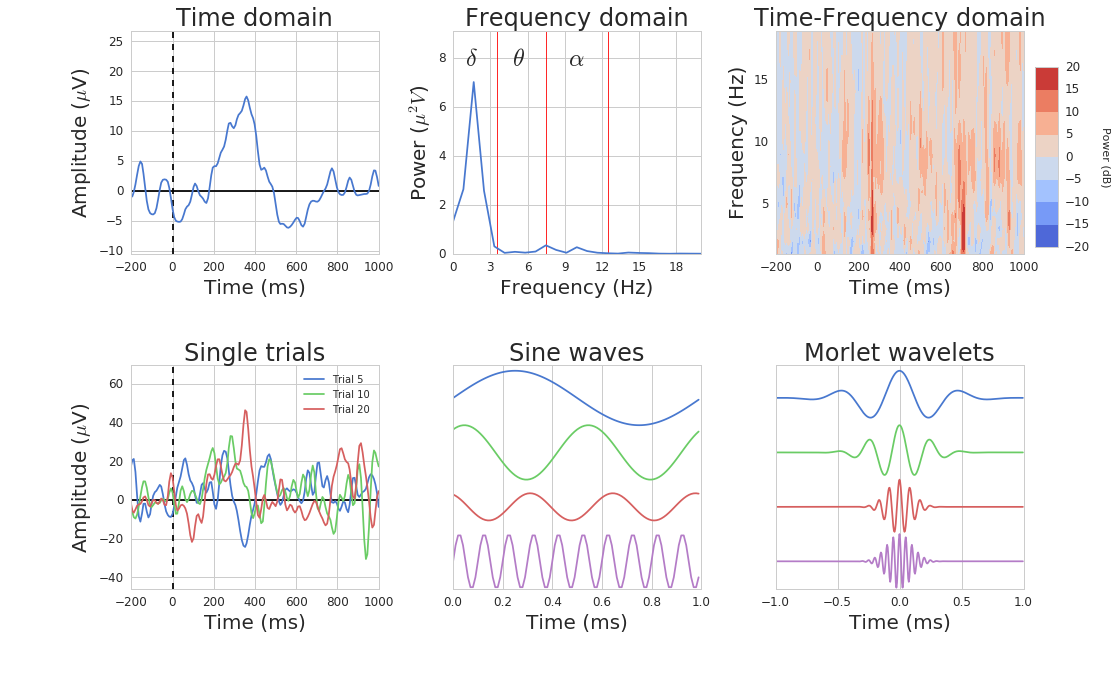

In [41]:
settings = {'axes.titlesize': 24,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12}

matplotlib.rcParams.update(settings)

srate = raw.info.get('sfreq')
time = epochs.average().to_data_frame().index

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), dpi=240)
fig.subplots_adjust(hspace=.5, wspace=.3)
ax1, ax2, ax3 = ax[0]
ax4, ax5, ax6 = ax[1]

pick = 0
trials = [5, 10, 20]
plot_average(epochs, pick, ax1)
plot_single(epochs, pick, trials, ax4)

plot_spectrum(epochs, pick, ax2, srate)
plot_sinewaves(ax5)

plot_wavelets(ax6)
plot_spectogram(epochs1, time, srate, ax3, fig)

#plt.savefig('comparison.png')

## some utility functions

In [34]:
from numpy.fft import fft, ifft

    
def create_sine(A, freq, phase, time):
    return A*np.sin(2*np.pi*freq*time + phase)
    return A*np.exp(1j * 2*np.pi*freq*time + phase)

    
def create_morlet(freq, wavetime, s=1):
    """
    Create a morlet wavelet.
    """
    
    sin = np.exp(1j * 2*np.pi*freq*wavetime)
    gauss = np.exp(-.5 * (wavetime**2 / s**2))
    return sin * gauss


def convolve_morlet(signal, morlet):
    """
    Compute the convolution of a signal and a morlet wavelet in the frequency
    domain via multiplication.
    """
    
    nconv = signal.size + morlet.size - 1
    
    fft_morlet = fft(morlet, nconv)
    fft_morlet = fft_morlet / np.max(fft_morlet) # scale so units don't change
    conv = ifft(fft(signal, nconv) * fft_morlet)
    
    ## the length of the convolution is greater than the original signal, so we have to
    ## remove half the signal size at the beginning and end of the convolution result
    morlet_half = morlet.size / 2
    return conv[morlet_half-1:-morlet_half]


def tf_decompose(epochs, freqs, range_cycles, srate, baseline=None):
    """
    Time-frequency decompose the EEG signal.
    """
    
    # unnecessary restriction, but let's keep it simple
    EEG = epochs.to_data_frame().reset_index('epoch')
    assert EEG.columns.size == 2, 'Only tf decompose one channel!'
    
    channel = np.array(EEG.iloc[:, 1].tolist()) # all the channel data
    trial_time = np.array(EEG.reset_index('time').time.tolist()) # rather ugly way of getting it
    
    ntrials = EEG.epoch.unique().size # number of trials
    npoints, _ = EEG.loc[EEG.epoch == 1, :].shape # number of time points in a trial
    ntotal = ntrials * npoints # number of total samples
    
    nfreqs = len(freqs)
    cmin, cmax = range_cycles
    cycles = np.logspace(np.log10(cmin), np.log10(cmax), nfreqs) / (2*np.pi*np.array(freqs))
    
    wavetime = np.arange(-.5, .5, 1.0 / srate)
    nconv = ntotal + len(wavetime) - 1
    
    fft_channel = fft(channel, n=nconv)
    half_morlet = len(wavetime) / 2
    
    # result of the decomposition, doing it over the concatenated trials for speed
    time_frequency = np.zeros([nfreqs, npoints])
    
    def closest(X, p):
        dist = X - p
        return np.argmin(dist**2)
    
    bmin, bmax = [closest(trial_time, x) for x in baseline]
    
    for i in range(nfreqs):
        f, s = freqs[i], cycles[i]
        morlet = np.exp(1j * 2*np.pi*f*wavetime) * np.exp(-.5 * (wavetime**2 / s**2))
        
        fft_morlet = fft(morlet, n=nconv)
        fft_morlet = fft_morlet / np.max(fft_morlet) # scale so units don't change
        
        conv = ifft(fft_channel * fft_morlet, n=nconv)
        conv = conv[half_morlet-1:-half_morlet]
        
        # cut up the whole convolution result into trials
        conv_trials = conv.reshape((npoints, ntrials))
        mean_power = (np.abs(conv_trials)**2).mean(1)
        
        if baseline:
            base_power = mean_power[bmin:bmax]
            mean_power = 10 * np.log10(mean_power / np.mean(base_power))
        
        # take the mean over trial power
        time_frequency[i, :] = mean_power
        
    return time_frequency

## plotting functions

In [40]:
def plot_average(epochs, pick, ax):
    """
    Given the epochs and a electrode (pick), plots the average ERP
    on the specific axis.
    """
    
    avg = epochs.average().to_data_frame().iloc[:, pick]
    
    scale = 1.7
    xmin, xmax = avg.index.min(), avg.index.max()
    ymin, ymax = np.min(avg).min()*scale, np.max(avg).max()*scale
    
    ax.plot(avg)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.vlines(0, ymin, ymax, linestyles='dashed')
    ax.hlines(0, xmin, xmax)
    ax.set_ylabel('Amplitude ($\mu$V)', fontsize=20)
    ax.set_xlabel('Time (ms)', fontsize=20)
    ax.set_title('Time domain')

    
def plot_single(epochs, pick, trials, ax):
    """
    Takes the epochs object, the electrode, and plots the single-trial
    ERPs on the axis.
    """
    
    single = epochs.to_data_frame().iloc[:, pick] # pick electrode
    single = single.reset_index(['condition', 'epoch'])
    
    pick_trials = single.epoch.apply(lambda x: x in trials)
    single = single.loc[pick_trials, :].drop(['condition'], axis=1)
    
    for key, grp in single.groupby('epoch'):
        ax.plot(grp.iloc[:, pick+1], label='Trial {0}'.format(key))
        
    ax.legend(loc='best')
    
    scale = 1.5
    xmin, xmax = single.index.min(), single.index.max()
    ymin, ymax = np.min(single).min()*scale, np.max(single).max()*scale
    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.vlines(0, ymin, ymax, linestyles='dashed')
    ax.hlines(0, single.index.min(), single.index.max())
    ax.set_ylabel('Amplitude ($\mu$V)', fontsize=20)
    ax.set_xlabel('Time (ms)', fontsize=20)
    ax.set_title('Single trials')

    
def plot_spectrum(epochs, pick, ax, srate, annotate=True):
    """
    Takes the epochs object and electrode and plots the power spectrum
    of the signal on choosen axis. Optionally annotates the plot with the
    names of the frequency bands (alpha, beta, etc.).
    """
    
    avg = epochs.average().to_data_frame().iloc[:, pick]
    
    N = len(avg)
    nyqvist = srate / 2.0
    freq = np.linspace(0, nyqvist, np.floor(N / 2) + 1)
    
    fourier = np.fft.fft(avg) / N
    power = (np.abs(fourier)**2)[:len(freq)]
    maxpower = np.max(power)
    
    scale = 1.3
    ax.plot(freq, power)
    ax.set_ylim(0, maxpower * scale)
    ax.set_xlim(0, 20)
    
    if annotate:
        # from Freeman & Quiroga (2012, p.31)
        freqs = {'delta': (0, 3.5), 'theta': (3.5, 7.5), 'alpha': (7.5, 12.5),
             'beta': (12.5, 30), 'gamma': (30, 60) }

        # add annotations for frequency band
        for key, val in freqs.items():
            down, up = val
            ax.vlines(up, 0, maxpower * scale, colors='red', linewidth=.6)
            ax.vlines(down, 0, maxpower * scale, colors='red', linewidth=.6)
            ax.annotate('$\{0}$'.format(key), xy=(np.mean(val) - .75, maxpower * (scale - .2)))

    ax.set_title('Frequency domain')
    ax.set_xlabel('Frequency (Hz)', fontsize=20)
    ax.set_ylabel('Power ($\mu^2 V$)', fontsize=20)
    ax.set_xticks(np.arange(0, 20, 3))

    
def plot_sinewaves(ax, srate=100, annotate=True):
    """
    Given an axis, plots a bunch of sine waves varying in amplitude, frequency, and phase.
    """
    
    # plot sine waves below
    ampl = [1, 1, .5, 1]
    freq = [1, 2, 3, 10]
    phase = [0, 1, 2, 0]
    spacing = [3, 1, -1, -3]
    time = np.arange(0, 1, 1 / 100.)
    
    for i in range(len(freq)):
        csine = create_sine(ampl[i], freq[i], phase[i], time)
        ax.plot(time, csine + spacing[i])

    ax.set_yticks([])
    ax.set_ylim(-4, 4.2)
    ax.set_title('Sine waves')
    ax.set_xlabel('Time (ms)', fontsize=20)


def plot_spectogram(epochs, time, srate, ax, fig):
    """
    Computes time-frequency decomposition on single trials and then averages.
    """
    
    freqs = np.arange(1, 20)
    range_cycles = [4, 7]
    time_frequency = tf_decompose(epochs, freqs, range_cycles, srate, baseline=[-200, 0])
    
    cont = ax.contourf(time, freqs, time_frequency, cmap=plt.cm.coolwarm)
    
    cbar_ax = fig.add_axes([.91, 0.6, 0.02, 0.25])
    cbar = fig.colorbar(cont, cax=cbar_ax)
    cbar.set_label('Power (dB)', rotation=270, labelpad=20)
    
    ax.set_xlabel('Time (ms)', fontsize=20)
    ax.set_ylabel('Frequency (Hz)', fontsize=20)
    ax.set_title('Time-Frequency domain')

    
def plot_wavelets(ax):
    """
    Given an axis, plots a bunch of morlet wavelets varying in width.
    """
    
    freq = [2, 4, 12, 20]
    width = [.3, .2, .1, .1]
    spacing = [3, 1, -1, -3]
    wavetime = np.arange(-1, 1, 1 / 200.)
    
    for i in range(len(freq)):
        morlet = create_morlet(freq[i], wavetime, s=width[i])
        ax.plot(wavetime, morlet + spacing[i])
    
    ax.set_yticks([])
    ax.set_ylim(-4, 4.2)
    ax.set_title('Morlet wavelets')
    ax.set_xlabel('Time (ms)', fontsize=20)